<a href="https://colab.research.google.com/github/KJanzon/project-nlp-business-case-automated-customers-reviews/blob/main/categories.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q transformers


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/reviews-project')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

In [ ]:
import functions
import importlib

importlib.reload(functions)

# Load your CSV file
train_df = functions.load_and_clean("/content/drive/MyDrive/reviews-project/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv")

test_df = functions.load_and_clean("/content/drive/MyDrive/reviews-project/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv")

# Merge them into one DataFrame
combined_df = pd.concat([train_df, test_df], ignore_index=True)


print("Train sentiment distribution:\n", combined_df["sentiment"].value_counts())


Train sentiment distribution:
 sentiment
positive    28908
negative     3060
Name: count, dtype: int64


In [ ]:
combined_df['product_info'] = combined_df.apply(
    lambda row: f"{row['name']} | {row['categories']} | {row['primaryCategories']}"
    if pd.notna(row['categories']) and pd.notna(row['primaryCategories'])
    else f"{row['name']} | {row['primaryCategories']}",  # fallback if categories is missing
    axis=1
)

combined_df['categories'] = combined_df['categories'].str.replace(r"[\[\]'\"\\]", "", regex=True)


## Generate sematic embeddings

In [ ]:
!pip install -U sentence-transformers

from sentence_transformers import SentenceTransformer

# Load a strong all-purpose model
model = SentenceTransformer('all-MiniLM-L6-v2')  # fast + accurate

# Embed the product_info text
embeddings = model.encode(combined_df['product_info'].tolist(), show_progress_bar=True)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 87.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/999 [00:00<?, ?it/s]

## KMeans Model

In [ ]:
from sklearn.cluster import KMeans

# Let's try 5 clusters for now
num_clusters = 6
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings)

# Assign to dataframe
combined_df['cluster'] = cluster_labels


In [ ]:
for i in range(num_clusters):
    print(f"\nCluster {i} Sample Products:")
    samples = combined_df[combined_df['cluster'] == i]['product_info'].sample(5, random_state=42)
    for product in samples:
        print("•", product)



Cluster 0 Sample Products:
• Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers | eBook Readers,Electronics Features,Walmart for Business,Tablets,See more Amazon Kindle Voyage (Wi-Fi),Electronics,Amazon Ereaders,Office Electronics,iPad & Tablets,Kindle E-readers,E-Readers & Accessories,All Tablets,See more Amazon Kindle Voyage 4GB, Wi-Fi  3G (Unlocked...,Amazon Book Reader,Computers & Tablets | Electronics
• Kindle E-reader - White, 6 Glare-Free Touchscreen Display, Wi-Fi - Includes Special Offers | Office,eBook Readers,Electronics Features,Walmart for Business,Tablets,Electronics,Amazon Ereaders,Office Electronics,iPad & Tablets,Kindle E-readers,All Tablets,Amazon Book Reader,Computers & Tablets | Office Supplies,Electronics
• Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers | eBook Readers,Electronics Fe

## Flan-t5-base model

In [ ]:
from transformers import pipeline

summarizer = pipeline("summarization", model="google/flan-t5-base")


config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

Device set to use cpu


In [ ]:
import pandas as pd

# Sample 5 product descriptions per cluster
cluster_samples = {}
for cluster_id in sorted(combined_df['cluster'].unique()):
    samples = combined_df[combined_df['cluster'] == cluster_id]['product_info'].dropna().sample(5, random_state=42).tolist()
    cluster_samples[cluster_id] = samples


In [ ]:
def summarize_cluster(samples):
    # Combine samples into one text block, keep it within token limits
    text = " | ".join(samples)
    return summarizer(text[:1000])[0]['summary_text']

# Generate labels for each cluster
cluster_map = {}
for cluster_id, samples in cluster_samples.items():
    print(f"\n🔍 Summarizing Cluster {cluster_id}...")
    summary = summarize_cluster(samples)
    print("Cluster", cluster_id, "→", summary)
    cluster_map[cluster_id] = summary




🔍 Summarizing Cluster 0...
Cluster 0 → Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers | eBook Readers,Electronics Features,Walmart for Business,Tablets,See more

🔍 Summarizing Cluster 1...
Cluster 1 → The Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Pink Kid-Proof Case | Fire Tablets, Tables, All tablets, Amazon tablets,Computers & Tablets | Electronics | Fire kids edition tablet, 7 display, wi-fi, 16GB, pink Kid-proof case | Fire tablets, learning toys, toys, tablets, amazon tablets, electronics, tech toys, movies, music, computers & tablets, kids' tablets, electronic, iPad & tablet,Tablets for Kids | Toys & Games, electronics | Fire Kids edition tablet , 7 screen, wi - fi, 16g, pink kid-proof case | fire tablets , learning toys, toys , tablet, amazon tablet s, electronics & electronics, kids ' tablets s , electronic , tv , music , children 's tablets, computers

🔍 Summarizing Cluster 

## Clustering by keyword


In [ ]:
def assign_category(text):
    text = text.lower()

    name_section = text.split('|')[0]  # everything before the first '|'

    accessories_keywords = ['charger', 'power bank', 'usb cable', 'usb', 'adapter', 'accessory']
    batteries_keywords = ['aa', 'aaa', 'battery', 'batteries', 'alkaline']
    tablet_keywords = ['tablet']
    e_reader_keywords = ['kindle', 'e-reader', 'ereader']
    smart_speaker_keywords = ['echo', 'tap', 'alexa']  # expand with 'tap' and 'alexa'

    if any(kw in name_section for kw in accessories_keywords):
        return "Accessories"
    elif any(kw in name_section for kw in batteries_keywords):
        return "Batteries"
    elif any(kw in name_section for kw in tablet_keywords):
        return "Tablet"
    elif any(kw in name_section for kw in e_reader_keywords):
        return "E-reader"
    elif any(kw in name_section for kw in smart_speaker_keywords):
        return "Smart Speaker"
    else:
        return "Other"



In [ ]:
combined_df['product_info_lower'] = combined_df['product_info'].str.lower()
combined_df['product_category'] = combined_df['product_info_lower'].apply(assign_category)

In [ ]:
combined_df['product_category'].value_counts()


,count
product_category,
Tablet,17195
Batteries,10858
Smart Speaker,2299
E-reader,1449
Other,88
Accessories,79


In [ ]:
categories = combined_df['product_category'].unique()

for category in categories:
    print(f"\n🔷 Category: {category}")
    samples = combined_df[combined_df['product_category'] == category]['product_info'].sample(10, random_state=42)
    for i, product in enumerate(samples, 1):
        print(f"{i}. {product}")



🔷 Category: Batteries
1. AmazonBasics AAA Performance Alkaline Batteries (36 Count) | AA,AAA,Health,Electronics,Health & Household,Camcorder Batteries,Camera & Photo,Batteries,Household Batteries,Robot Check,Accessories,Camera Batteries,Health and Beauty,Household Supplies,Batteries & Chargers,Health, Household & Baby Care,Health Personal Care | Health & Beauty
2. AmazonBasics AAA Performance Alkaline Batteries (36 Count) | AA,AAA,Health,Electronics,Health & Household,Camcorder Batteries,Camera & Photo,Batteries,Household Batteries,Robot Check,Accessories,Camera Batteries,Health and Beauty,Household Supplies,Batteries & Chargers,Health, Household & Baby Care,Health Personal Care | Health & Beauty
3. AmazonBasics AA Performance Alkaline Batteries (48 Count) - Packaging May Vary | AA,AAA,Electronics Features,Health,Electronics,Health & Household,Camcorder Batteries,Camera & Photo,Batteries,Household Batteries,Accessories,Camera Batteries,Health and Beauty,Household Supplies,Batteries & 

## Use LogisticRegression to classify
Classifies based on keywords. Better than just keyword match since it also learns patterns:
Adapts to learned word combos (e.g., "Fire device", "Echo Studio")
Can learn "usb power" = "charger"


In [ ]:
import functions
import importlib

importlib.reload(functions)

# Load your CSV file
train_df = functions.load_and_clean("/content/drive/MyDrive/reviews-project/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv")

test_df = functions.load_and_clean("/content/drive/MyDrive/reviews-project/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv")

# Merge them into one DataFrame
df = pd.concat([train_df, test_df], ignore_index=True)

In [ ]:
df['name_clean'] = df['name'].fillna("").str.lower()
df['label'] = df['name_clean'].apply(assign_category)

df['label'].value_counts()


,count
label,
Tablet,17195
Batteries,10858
Smart Speaker,2299
E-reader,1449
Accessories,85
Other,82


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    df['name_clean'], df['label'], test_size=0.2, stratify=df['label'], random_state=42
)


from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=3000, ngram_range=(1, 2))
X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

clf = LogisticRegression(max_iter=200, class_weight='balanced')
clf.fit(X_train_vec, y_train)

# Predict and evaluate
y_pred = clf.predict(X_val_vec)
print(classification_report(y_val, y_pred))


               precision    recall  f1-score   support

  Accessories       1.00      1.00      1.00        17
    Batteries       1.00      1.00      1.00      2172
     E-reader       1.00      1.00      1.00       290
        Other       0.70      1.00      0.82        16
Smart Speaker       1.00      1.00      1.00       460
       Tablet       1.00      1.00      1.00      3439

     accuracy                           1.00      6394
    macro avg       0.95      1.00      0.97      6394
 weighted avg       1.00      1.00      1.00      6394



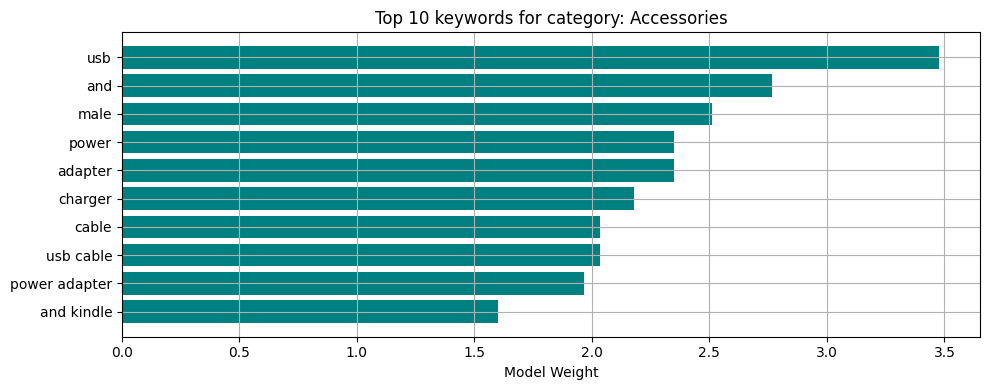

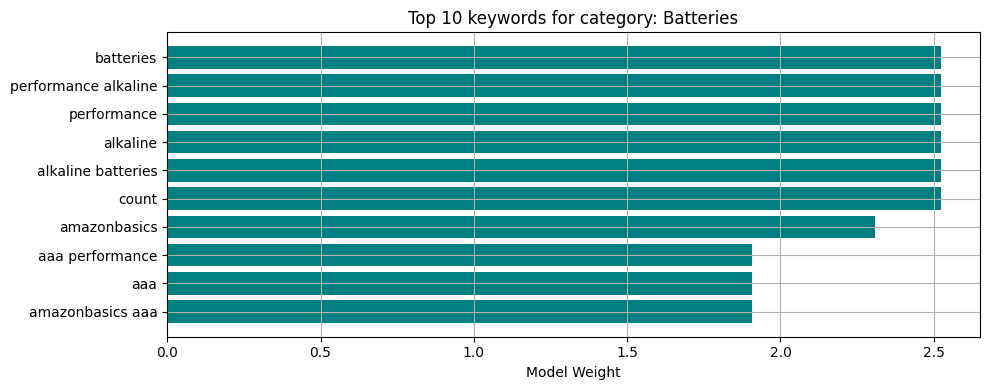

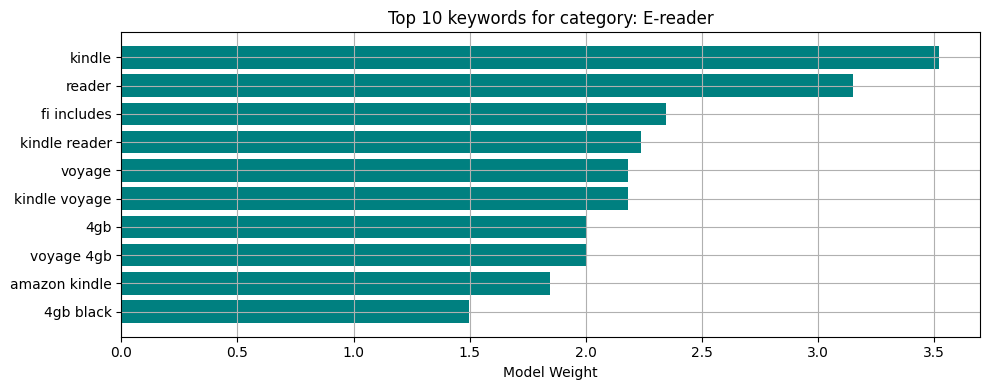

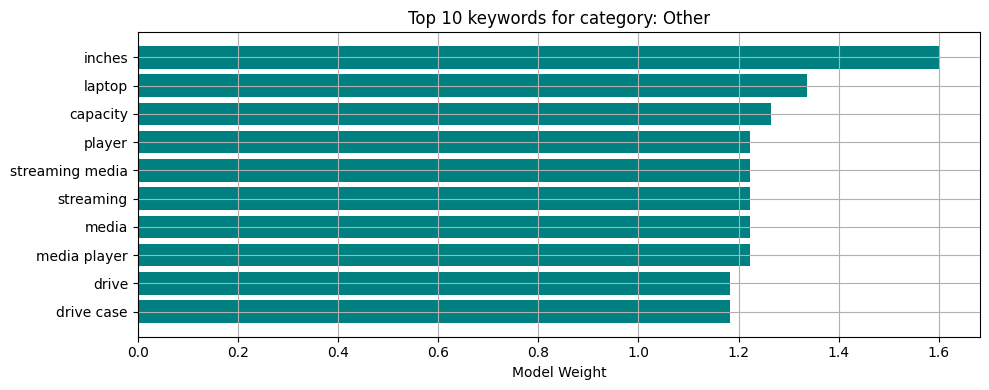

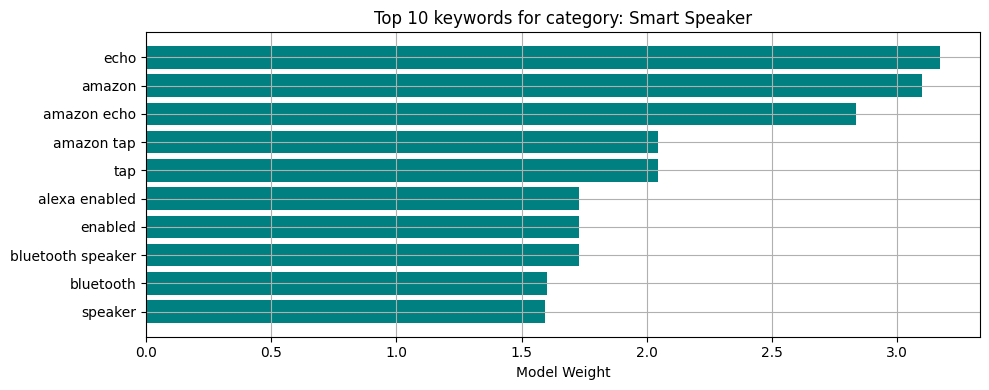

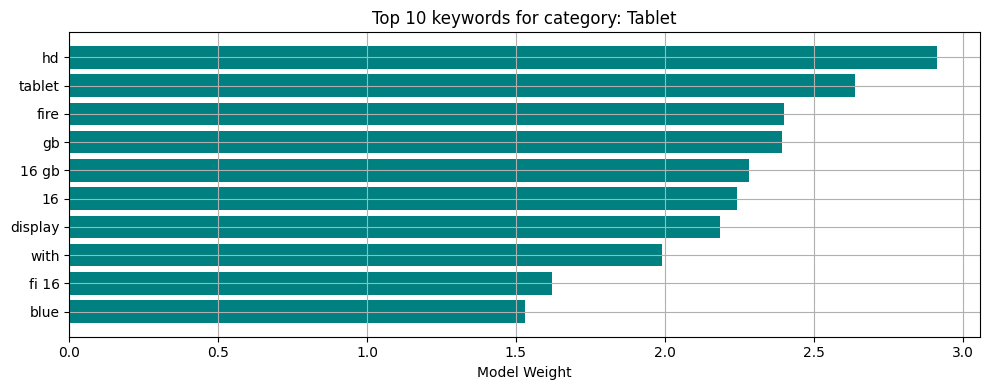

In [ ]:
import numpy as np

# Get class names (e.g., "Tablet", "Batteries", etc.)
class_labels = clf.classes_

# Get the feature names (tokens/words/phrases from TF-IDF)
feature_names = vectorizer.get_feature_names_out()


import matplotlib.pyplot as plt

def plot_top_keywords(class_index, top_n=10):
    class_name = class_labels[class_index]
    coef = clf.coef_[class_index]

    # Get indices of top N features
    top_indices = np.argsort(coef)[-top_n:][::-1]
    top_features = feature_names[top_indices]
    top_weights = coef[top_indices]

    # Plot
    plt.figure(figsize=(10, 4))
    plt.barh(top_features[::-1], top_weights[::-1], color='teal')
    plt.title(f"Top {top_n} keywords for category: {class_name}")
    plt.xlabel("Model Weight")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

for i in range(len(class_labels)):
    plot_top_keywords(i, top_n=10)


In [ ]:
for category in df['label'].unique():
    print(f"\n🔷 Category: {category} (showing 20 random products)")

    # Sample 20 rows from this category
    samples = df[df['label'] == category]['name'].dropna().sample(20, random_state=42)

    for i, name in enumerate(samples, 1):
        print(f"{i}. {name}")



🔷 Category: Batteries (showing 20 random products)
1. AmazonBasics AAA Performance Alkaline Batteries (36 Count)
2. AmazonBasics AAA Performance Alkaline Batteries (36 Count)
3. AmazonBasics AA Performance Alkaline Batteries (48 Count) - Packaging May Vary
4. AmazonBasics AAA Performance Alkaline Batteries (36 Count)
5. AmazonBasics AAA Performance Alkaline Batteries (36 Count)
6. AmazonBasics AAA Performance Alkaline Batteries (36 Count)
7. AmazonBasics AAA Performance Alkaline Batteries (36 Count)
8. AmazonBasics AA Performance Alkaline Batteries (48 Count) - Packaging May Vary
9. AmazonBasics AAA Performance Alkaline Batteries (36 Count)
10. AmazonBasics AA Performance Alkaline Batteries (48 Count) - Packaging May Vary
11. AmazonBasics AAA Performance Alkaline Batteries (36 Count)
12. AmazonBasics AAA Performance Alkaline Batteries (36 Count)
13. AmazonBasics AAA Performance Alkaline Batteries (36 Count)
14. AmazonBasics AAA Performance Alkaline Batteries (36 Count)
15. AmazonBasic

In [ ]:
import pandas as pd

# Create a DataFrame for validation results
val_results = pd.DataFrame({
    'name': X_val,
    'true_label': y_val,
    'predicted_label': y_pred
})

# How many incorrect predictions do we have?
n_incorrect = len(incorrect_preds)

# Pick the smaller of 20 or however many we have
n_sample = min(20, n_incorrect)

# Sample safely
incorrect_samples = incorrect_preds.sample(n_sample, random_state=42)

# Print
for i, row in incorrect_samples.iterrows():
    print(f"\n🔹 Product: {row['name']}")
    print(f"   🏷️ True Label: {row['true_label']}")
    print(f"   🤖 Predicted: {row['predicted_label']}")




🔹 Product: amazonbasics 15.6-inch laptop and tablet bag
   🏷️ True Label: Tablet
   🤖 Predicted: Other

🔹 Product: amazonbasics 15.6-inch laptop and tablet bag
   🏷️ True Label: Tablet
   🤖 Predicted: Other

🔹 Product: amazonbasics 15.6-inch laptop and tablet bag
   🏷️ True Label: Tablet
   🤖 Predicted: Other

🔹 Product: echo spot pair kit (black)
   🏷️ True Label: Smart Speaker
   🤖 Predicted: Other

🔹 Product: amazonbasics 15.6-inch laptop and tablet bag
   🏷️ True Label: Tablet
   🤖 Predicted: Other

🔹 Product: amazonbasics 15.6-inch laptop and tablet bag
   🏷️ True Label: Tablet
   🤖 Predicted: Other

🔹 Product: amazonbasics 15.6-inch laptop and tablet bag
   🏷️ True Label: Tablet
   🤖 Predicted: Other


In [ ]:
# Vectorize the full 'name_clean' column
X_all = vectorizer.transform(df['name_clean'])

# Predict categories
df['mainCategory'] = clf.predict(X_all)


# Save to CSV
df.to_csv("products_with_mainCategory.csv", index=False)

# Optional: if you're in Colab and want to download directly
from google.colab import files
files.download("products_with_mainCategory.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>